In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')


import copy
from time import time
from tqdm import tqdm
import sys
#from google.colab import drive
#drive.mount('/content/gdrive/')
#sys.path.append('/content/gdrive/My Drive/PLSR-ABC')

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn import datasets, linear_model

In [1]:
from Hive import Hive
from Hive import Utilities

## Dataset Preparation

In [2]:
# Load raw dataset
dataset = pd.read_csv('data/dataset_old.csv')

# Slice dataset into input (X, wavelength features) and output (Y, flavonoid value)
num_features = 224
X = dataset.iloc[:, :num_features]
Y = dataset.iloc[:, 224:225]
wavelengths = X.columns.values.tolist()

# Normalize each column of the data
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X.values))
Y = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(Y.values))

# Split dataset
X, X_test, Y, Y_test = train_test_split(X, Y, test_size = 0.25)

print('Training dataset dim. {}'.format(X.shape))
print('Testing dataset dim. {}'.format(X_test.shape))

NameError: name 'pd' is not defined

## Regression with PLS and Optimization via ABC

In [80]:
# Declare objective function to be minimized by ABC
def rmse_abc_ALL(B):
    # Declare parameter B to be optimized
    B = np.reshape(np.array(B), (num_features, 1))
    # Declare input X to be optimized
    x_train = X - PLSR_ALL.x_mean_
    x_train /= PLSR_ALL.x_std_
    return np.sqrt(mse(Y, np.dot(x_train, B) + PLSR_ALL.y_mean_))

def rmse_abc_SEL(B):
    # Declare parameter B to be optimized
    B = np.reshape(np.array(B), (num_selected, 1))
    # Declare input X to be optimized
    x_train = X_SEL - PLSR_SEL.x_mean_
    x_train /= PLSR_SEL.x_std_
    return np.sqrt(mse(Y, np.dot(x_train, B) + PLSR_SEL.y_mean_))

In [102]:
'''
=====================================================
CORE METHOD
-------------
REGRESSION WITH PLS & PARAMETER OPTIMIZATION VIA ABC
=====================================================
'''
st = time()

'''Step 1. Select Optimum Number of PLSR Components'''
rmse_ori = []
fold_num = 5
max_components = num_features - 1
#for n_comp, i in zip(range(max_components), tqdm(range(max_components))):
    #if n_comp == 163:
        # Regress data with corresponding number of components
#PLSR_ALL = PLSRegression(n_components = n_comp + 1)
PLSR_ALL = PLSRegression(n_components = 40)
PLSR_ALL.fit(X, Y)
        # Declare input X to be optimized
x_train = X - PLSR_ALL.x_mean_
x_train /= PLSR_ALL.x_std_
        # Calculate predicted value with Cross-validation
Y_cv = cross_val_predict(PLSR_ALL, X, Y, cv = fold_num)
        # Get PLSR RMSE
rmse = np.sqrt(mse(Y, Y_cv))
rmse_ori.append(rmse)
        # Get limit of coeficient/parameters value B
coef_plsr_ALL = PLSR_ALL.coef_

# Get optimum component
opt_component = rmse_ori.index(min(rmse_ori)) # 163 paling bagus

In [103]:
Y_train_meas_ALL = Y
Y_train_pred_ALL = PLSR_ALL.predict(X)
Y_test_meas_ALL = Y_test
Y_test_pred_ALL = PLSR_ALL.predict(X_test)

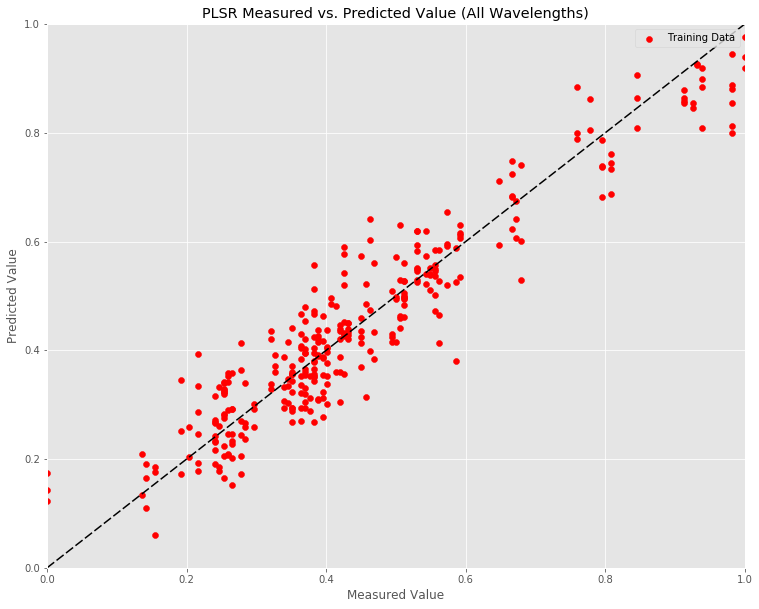

In [104]:
#-- Plot Predicted vs. Measured Values (ALL wavelengths)
plt.title('PLSR Measured vs. Predicted Value (All Wavelengths)')
plt.xlabel('Measured Value')
plt.ylabel('Predicted Value')
gradien_x = [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
gradien_y = [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
plt.scatter(Y_train_meas_ALL, Y_train_pred_ALL, label = 'Training Data',color = 'red')
#plt.scatter(Y_test_meas_ALL, Y_test_pred_ALL, label = 'Test Data',color = 'blue')
plt.plot(gradien_x,gradien_y,color='black',dashes=[6, 2])
plt.legend(loc = 'upper right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.gcf().set_size_inches(12.5, 10)
plt.show()



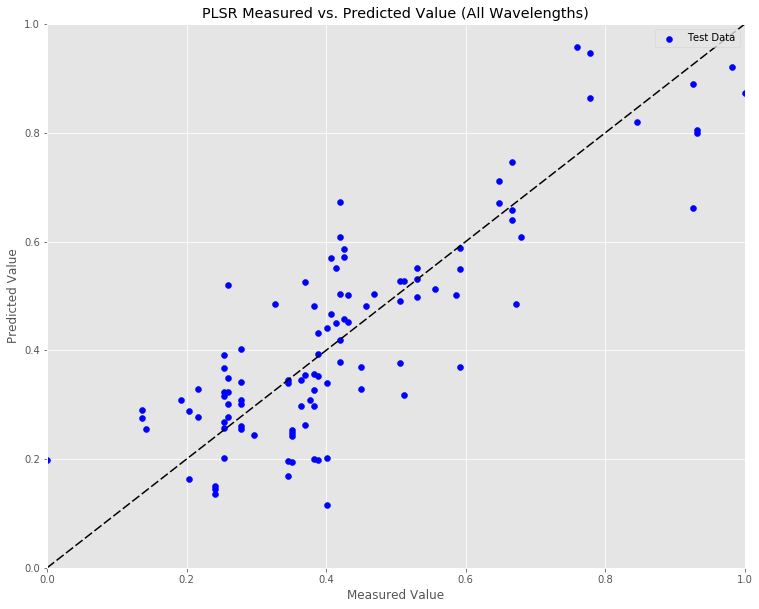

In [105]:
#-- Plot Predicted vs. Measured Values (ALL wavelengths)
plt.title('PLSR Measured vs. Predicted Value (All Wavelengths)')
plt.xlabel('Measured Value')
plt.ylabel('Predicted Value')
gradien_x = [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
gradien_y = [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
#plt.scatter(Y_train_meas_ALL, Y_train_pred_ALL, label = 'Training Data',color = 'red')
plt.scatter(Y_test_meas_ALL, Y_test_pred_ALL, label = 'Test Data',color = 'blue')
plt.plot(gradien_x,gradien_y,color='black',dashes=[6, 2])
plt.legend(loc = 'upper right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.gcf().set_size_inches(12.5, 10)
plt.show()

In [106]:
r2_Test = r2_score(Y_test_meas_ALL, Y_test_pred_ALL)

In [107]:
r2_Test

0.6751872924066016

In [108]:
r2_ALL = r2_score(Y_train_meas_ALL, Y_train_pred_ALL)

In [109]:
r2_ALL

0.8953748314893524


100%|█████████▉| 223/224 [07:09<00:01,  1.08s/it]

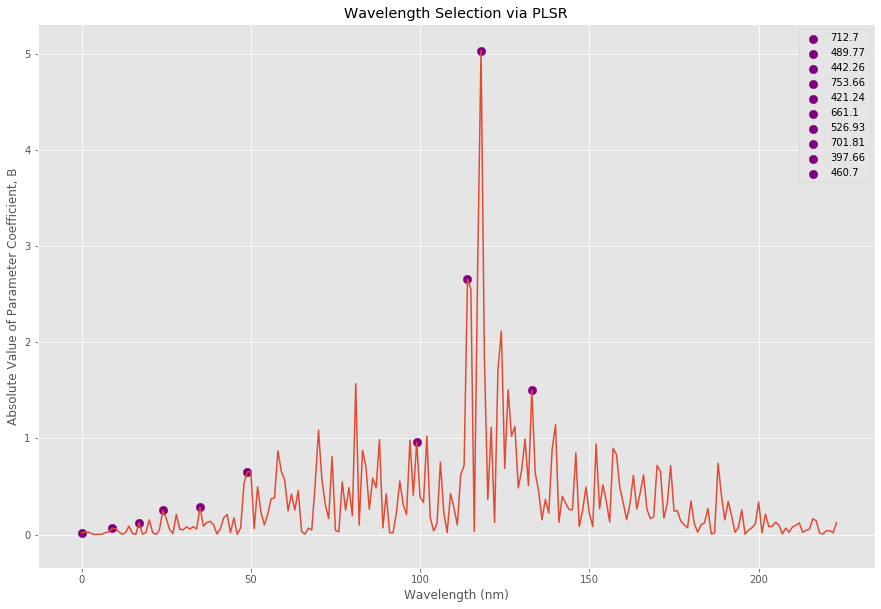

In [6]:
'''Step 2. Wavelength Selection via PLSR Coefficient'''
num_selected = 10
selected_wavelength_rmse = []
for wavelength_idx, j in zip(range(num_features), tqdm(range(num_features))):
    # Regress data with corresponding number of components
    PLSR_WS = PLSRegression(n_components = opt_component)
    PLSR_WS.fit(X.loc[:, X.columns != wavelength_idx], Y)
    # Calculate predicted value with Cross-validation
    Y_cv = cross_val_predict(PLSR_ALL, X.loc[:, X.columns != wavelength_idx], Y, cv = fold_num)
    # Get PLSR RMSE
    rmse_selected = np.sqrt(mse(Y, Y_cv))
    selected_wavelength_rmse.append(rmse_selected - min(rmse_ori))

selected_wavelengths = []
selected_wavelengths_idx = np.argsort(np.array(selected_wavelength_rmse))[::-1][:num_selected]
for idx in selected_wavelengths_idx:
    selected_wavelengths.append(wavelengths[idx])
    plt.scatter(idx, np.abs(PLSR_ALL.coef_)[idx], label = wavelengths[idx], s = 70, c = 'purple')

plt.plot([i for i in range(len(PLSR_ALL.coef_))], np.abs(PLSR_ALL.coef_))
plt.legend(loc = 'upper right')
plt.title('Wavelength Selection via PLSR')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absolute Value of Parameter Coefficient, B')
plt.gcf().set_size_inches(15, 10)
plt.show()

In [7]:
'''Step 3. Re-fit PLSR for Selected Wavelengths'''
# Make dataframe of selected wavelengths
X_SEL = X.loc[:, X.columns == selected_wavelengths_idx[0]]
X_SEL_test = X_test.loc[:, X_test.columns == selected_wavelengths_idx[0]]
for idx in range(1, len(selected_wavelengths_idx)):
    X_SEL = pd.concat([X_SEL, X.loc[:, X.columns == selected_wavelengths_idx[idx]]], axis = 1)
    X_SEL_test = pd.concat([X_SEL_test, X_test.loc[:, X_test.columns == selected_wavelengths_idx[idx]]], axis = 1)

# Regress data with selected wavelengths
PLSR_SEL = PLSRegression(n_components = num_selected)
PLSR_SEL.fit(X_SEL, Y)
# Calculate predicted value with Cross-validation
Y_cv = cross_val_predict(PLSR_SEL, X_SEL, Y, cv = fold_num)
# Get PLSR RMSE
rmse_selected = np.sqrt(mse(Y, Y_cv))
# Get limit of coeficient/parameters value B
coef_plsr_SEL = PLSR_SEL.coef_

In [ ]:
len(Y_cv)

In [8]:
'''Step 4. Optimization of PLSR w/ Selected Wavelengths via ABC'''
# Prepare ABC
n_bees = 50
iter_count = 1
lr = 0.0001

# Prepare ABC class for ALL wavelengths
lower_lim_ALL = [b - (abs(b)*lr) for b in coef_plsr_ALL] 
upper_lim_ALL = [b - (abs(b)*lr) for b in coef_plsr_ALL]

abc_model = Hive.BeeHive(lower = lower_lim_ALL,
                         upper = upper_lim_ALL,
                         fun = rmse_abc_ALL,
                         numb_bees = n_bees,
                         max_itrs = iter_count)

# Optimize coefficient/parameters value B
cost = abc_model.run()
rmse_optimized_ALL = abc_model.best
coef_optimized_ALL = abc_model.solution

# Prepare ABC class for SELECTED wavelengths
lower_lim_SEL = [b - (abs(b)*lr) for b in coef_plsr_SEL] 
upper_lim_SEL = [b - (abs(b)*lr) for b in coef_plsr_SEL]

abc_model = Hive.BeeHive(lower = lower_lim_SEL,
                         upper = upper_lim_SEL,
                         fun = rmse_abc_SEL,
                         numb_bees = n_bees,
                         max_itrs = iter_count)

# Optimize coefficient/parameters value B
cost = abc_model.run()
rmse_optimized_SEL = abc_model.best
coef_optimized_SEL = abc_model.solution

In [ ]:
len(rmse_abc_ALL)

In [ ]:
len(coef_optimized_ALL)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


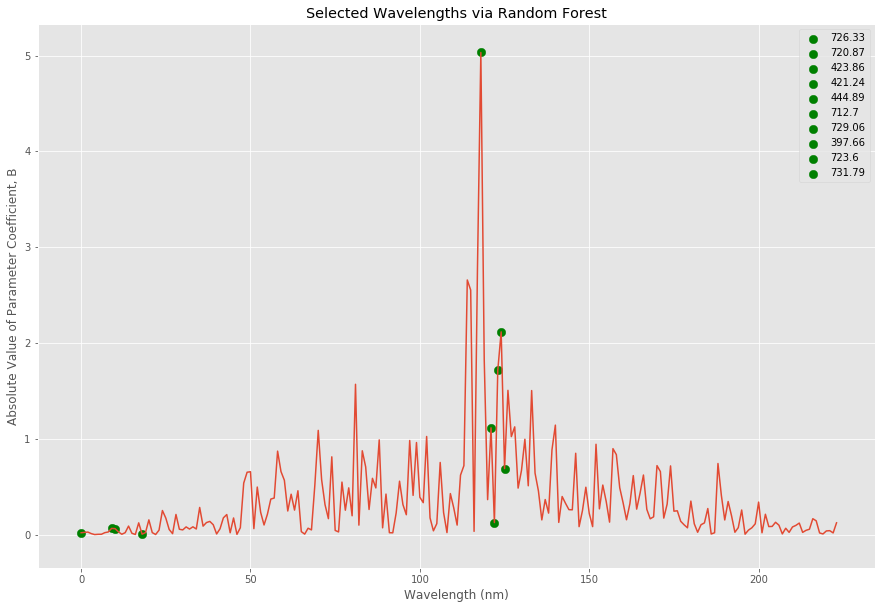

In [9]:
'''
==============================
COMPARISON WITH RANDOM FOREST
==============================
'''
# Random Forest for regression
rf = RandomForestRegressor()
rf.fit(X, Y)
rf_pred = rf.predict(X_test)
rmse_rf = np.sqrt(mse(Y_test, rf_pred))
r2_rf = r2_score(Y_test, rf_pred)
# Examine Random Forest selected features/wavelengths
rf_SEL_idx = np.flip(np.argsort(rf.feature_importances_))[:num_selected]

# Compare selected features
selected_wavelengths_rf = []
for idx in rf_SEL_idx:
    selected_wavelengths_rf.append(wavelengths[idx])
    plt.scatter(idx, np.abs(PLSR_ALL.coef_)[idx], label = wavelengths[idx], s = 70, c = 'green')

plt.plot([i for i in range(len(PLSR_ALL.coef_))], np.abs(PLSR_ALL.coef_))
plt.legend(loc = 'upper right')
plt.title('Selected Wavelengths via Random Forest')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absolute Value of Parameter Coefficient, B')
plt.gcf().set_size_inches(15, 10)
plt.show()

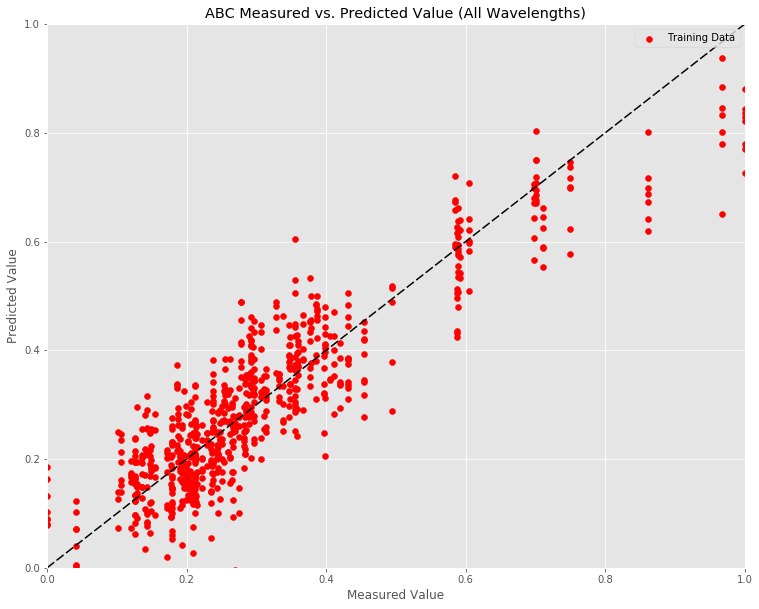

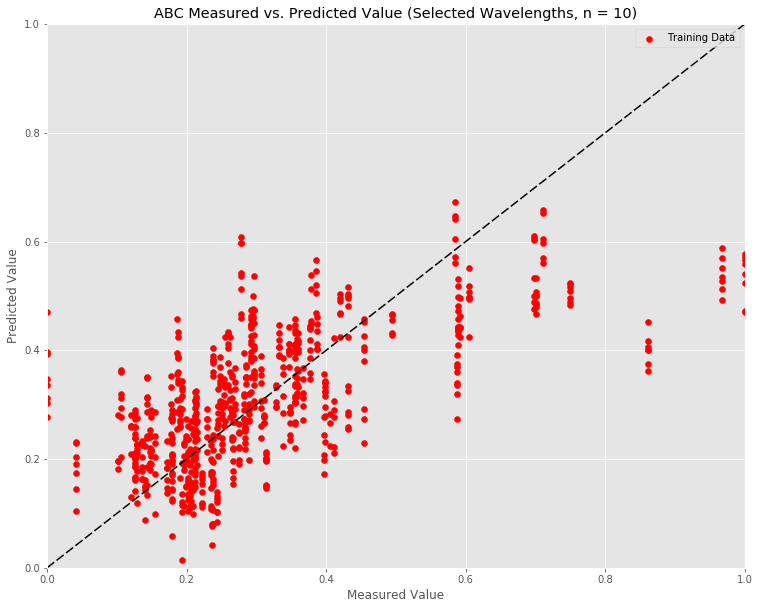

RESULT SUMMARY - PLSR + ABC
Optimum Number of PLSR Components         : 27
Selected Wavelengths via PLSR             : ['712.7', '489.77', '442.26', '753.66', '421.24', '661.1', '526.93', '701.81', '397.66', '460.7']
PLSR RMSE (w/ ALL wavelengths)            : 0.11486842861039696
PLSR RMSE (w/ SELECTED wavelengths)       : 0.13903714056921018
PLSR+ABC RMSE (w/ ALL wavelengths)        : 0.07833199241363463
PLSR+ABC RMSE (w/ SELECTED wavelengths)   : 0.13620659703646193
PLSR+ABC R2 (w/ ALL wavelengths)          : 0.46187649597155434
PLSR+ABC R2 (w/ SELECTED wavelengths)     : 0.4058910955532433
COMPARISON W/ RANDOM FOREST
Selected Wavelengths via Random Forest    : ['726.33', '720.87', '423.86', '421.24', '444.89', '712.7', '729.06', '397.66', '723.6', '731.79']
Random Forest RMSE                        : 0.08814861143723818
Random Forest R2                          : 0.723922357780998


In [53]:
'''=============== Calculate Final Prediction =============== '''
#------ ALL WAVELENGTHS
# Training Data; Measured Value
X_train_meas_ALL = X.copy()
Y_train_meas_ALL = Y.copy()
# Training Data; Predicted Value
X_train_pred_ALL = (X - PLSR_ALL.x_mean_)/PLSR_ALL.x_std_
Y_train_pred_ALL = np.dot(X_train_pred_ALL, coef_optimized_ALL) + PLSR_ALL.y_mean_
# Testing Data; Measured Value
X_test_meas_ALL = X_test.copy()
Y_test_meas_ALL = Y_test.copy()
# Testing Data; Predicted Value
X_test_pred_ALL = (X_test - PLSR_ALL.x_mean_)/PLSR_ALL.x_std_
Y_test_pred_ALL = np.dot(X_test_pred_ALL, coef_optimized_ALL) + PLSR_ALL.y_mean_

#------ SELECTED WAVELENGTHS
# Training Data; Measured Value
X_train_meas_SEL = X_SEL.copy()
Y_train_meas_SEL = Y.copy()
# Training Data; Predicted Value
X_train_pred_SEL = (X_SEL - PLSR_SEL.x_mean_)/PLSR_SEL.x_std_
Y_train_pred_SEL = np.dot(X_train_pred_SEL, coef_optimized_SEL) + PLSR_SEL.y_mean_
# Testing Data; Measured Value
X_test_meas_SEL = X_SEL_test.copy()
Y_test_meas_SEL = Y_test.copy()
# Testing Data; Predicted Value
X_test_pred_SEL = (X_SEL_test - PLSR_SEL.x_mean_)/PLSR_SEL.x_std_
Y_test_pred_SEL = np.dot(X_test_pred_SEL, coef_optimized_SEL) + PLSR_SEL.y_mean_

# Calculate R2 Score (PLSR+ABC)
r2_ALL = r2_score(Y_test_meas_ALL, Y_test_pred_ALL)
r2_SEL = r2_score(Y_test_meas_SEL, Y_test_pred_SEL)

regr = linear_model.LinearRegression()



gradien_x = [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
gradien_y = [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]

#-- Plot Predicted vs. Measured Values (ALL wavelengths)
plt.title('ABC Measured vs. Predicted Value (All Wavelengths)')
plt.xlabel('Measured Value')
plt.ylabel('Predicted Value')



plt.scatter(Y_train_meas_ALL, Y_train_pred_ALL, label = 'Training Data',color = 'red')
#plt.scatter(Y_test_meas_ALL, Y_test_pred_ALL, label = 'Test Data',color = 'blue')
#plt.plot(Y_cv)
plt.legend(loc = 'upper right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(gradien_x,gradien_y,color='black',dashes=[6, 2])
plt.gcf().set_size_inches(12.5, 10)
plt.show()

#-- Plot Predicted vs. Measured Values (SELECTED wavelengths)
plt.title('ABC Measured vs. Predicted Value (Selected Wavelengths, n = {})'.format(num_selected))
plt.xlabel('Measured Value')
plt.ylabel('Predicted Value')
plt.scatter(Y_train_meas_SEL, Y_train_pred_SEL, label = 'Training Data',color = 'red')
regr.fit(Y_train_meas_SEL, Y_train_pred_SEL)
#plt.scatter(Y_test_meas_SEL, Y_test_pred_SEL, label = 'Test Data',color = 'blue')
#plt.plot(X_test_pred_SEL, Y_test_pred_SEL, color='black', linewidth=3)
plt.plot(gradien_x,gradien_y,color='black',dashes=[6, 2])
plt.legend(loc = 'upper right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.gcf().set_size_inches(12.5, 10)
plt.show()





print('======================================================================')
print('RESULT SUMMARY - PLSR + ABC')
print('======================================================================')
print('Optimum Number of PLSR Components         : {}'.format(opt_component))
print('Selected Wavelengths via PLSR             : {}'.format(selected_wavelengths))
print('PLSR RMSE (w/ ALL wavelengths)            : {}'.format(min(rmse_ori)))
print('PLSR RMSE (w/ SELECTED wavelengths)       : {}'.format(rmse_selected))
print('======================================================================')
print('PLSR+ABC RMSE (w/ ALL wavelengths)        : {}'.format(rmse_optimized_ALL))
print('PLSR+ABC RMSE (w/ SELECTED wavelengths)   : {}'.format(rmse_optimized_SEL))
print('PLSR+ABC R2 (w/ ALL wavelengths)          : {}'.format(r2_ALL))
print('PLSR+ABC R2 (w/ SELECTED wavelengths)     : {}'.format(r2_SEL))
print('======================================================================')
print('COMPARISON W/ RANDOM FOREST')
print('======================================================================')
print('Selected Wavelengths via Random Forest    : {}'.format(selected_wavelengths_rf))
print('Random Forest RMSE                        : {}'.format(rmse_rf))
print('Random Forest R2                          : {}'.format(r2_rf))

In [2]:
X.Copy()

NameError: name 'X' is not defined

In [51]:
len(Y_test_meas_ALL)

243

In [ ]:
'''
PREPARE FOR PLSR CROSS-VALIDATION
'''
PLSR_ALL = PLSRegression(opt_component)
PLSR_ALL.fit(X, Y)

PLSR_SEL = PLSRegression(num_selected)
PLSR_SEL.fit(X_SEL, Y)

PLSR_ABC_ALL = copy.deepcopy(PLSR_ALL)
PLSR_ABC_ALL.coef_ = coef_optimized_ALL

PLSR_ABC_SEL = copy.deepcopy(PLSR_SEL)
PLSR_ABC_SEL.coef_ = coef_optimized_SEL

print('PLSR and PLSR-ABC Prepared.')

In [ ]:
# PLSR (w / ALL wavelengths) Cross-validation 



RMSE_train = []
RMSE_test = []
R2_train = []
R2_test = []
for fold, _ in zip(range(2, 7), tqdm(range(5))):
    pred_train = cross_val_predict(PLSR_ALL, X, Y, cv = fold)
    pred_test = cross_val_predict(PLSR_ALL, X_test, Y_test, cv = fold)

    RMSE_train.append(np.sqrt(mse(Y, pred_train)))
    RMSE_test.append(np.sqrt(mse(Y_test, pred_test)))
    R2_train.append(r2_score(Y, pred_train))
    R2_test.append(r2_score(Y_test, pred_test))

RMSE_train.append(np.average(RMSE_train))
RMSE_test.append(np.average(RMSE_test))
R2_train.append(np.average(R2_train))
R2_test.append(np.average(R2_test))

pd.DataFrame(data = {'RMSE Train': RMSE_train,
                     'RMSE Test': RMSE_test,
                     'R2 Train': R2_train,
                     'R2 Test': R2_test},
             index = ['1', '2', '3', '4', '5', 'Average'])

In [ ]:
# PLSR (w / SELECTED wavelengths) Cross-validation 
RMSE_train = []
RMSE_test = []
R2_train = []
R2_test = []
for fold, _ in zip(range(2, 7), tqdm(range(5))):
    pred_train = cross_val_predict(PLSR_SEL, X, Y, cv = fold)
    pred_test = cross_val_predict(PLSR_SEL, X_test, Y_test, cv = fold)

    RMSE_train.append(np.sqrt(mse(Y, pred_train)))
    RMSE_test.append(np.sqrt(mse(Y_test, pred_test)))
    R2_train.append(r2_score(Y, pred_train))
    R2_test.append(r2_score(Y_test, pred_test))

RMSE_train.append(np.average(RMSE_train))
RMSE_test.append(np.average(RMSE_test))
R2_train.append(np.average(R2_train))
R2_test.append(np.average(R2_test))

pd.DataFrame(data = {'RMSE Train': RMSE_train,
                     'RMSE Test': RMSE_test,
                     'R2 Train': R2_train,
                     'R2 Test': R2_test},
             index = ['1', '2', '3', '4', '5', 'Average'])

In [ ]:
# PLSR-ABC (w / ALL wavelengths) Cross-validation 
RMSE_train = []
RMSE_test = []
R2_train = []
R2_test = []
for fold, _ in zip(range(2, 7), tqdm(range(5))):
    pred_train = cross_val_predict(PLSR_ABC_ALL, X, Y, cv = fold)
    pred_test = cross_val_predict(PLSR_ABC_ALL, X_test, Y_test, cv = fold)

    RMSE_train.append(np.sqrt(mse(Y, pred_train)))
    RMSE_test.append(np.sqrt(mse(Y_test, pred_test)))
    R2_train.append(r2_score(Y, pred_train))
    R2_test.append(r2_score(Y_test, pred_test))

RMSE_train.append(np.average(RMSE_train))
RMSE_test.append(np.average(RMSE_test))
R2_train.append(np.average(R2_train))
R2_test.append(np.average(R2_test))

pd.DataFrame(data = {'RMSE Train': RMSE_train,
                     'RMSE Test': RMSE_test,
                     'R2 Train': R2_train,
                     'R2 Test': R2_test},
             index = ['1', '2', '3', '4', '5', 'Average'])

In [ ]:
# PLSR-ABC (w / SELECTED wavelengths) Cross-validation 
RMSE_train = []
RMSE_test = []
R2_train = []
R2_test = []
for fold, _ in zip(range(2, 7), tqdm(range(5))):
    pred_train = cross_val_predict(PLSR_ABC_SEL, X, Y, cv = fold)
    pred_test = cross_val_predict(PLSR_ABC_SEL, X_test, Y_test, cv = fold)

    RMSE_train.append(np.sqrt(mse(Y, pred_train)))
    RMSE_test.append(np.sqrt(mse(Y_test, pred_test)))
    R2_train.append(r2_score(Y, pred_train))
    R2_test.append(r2_score(Y_test, pred_test))

RMSE_train.append(np.average(RMSE_train))
RMSE_test.append(np.average(RMSE_test))
R2_train.append(np.average(R2_train))
R2_test.append(np.average(R2_test))

pd.DataFrame(data = {'RMSE Train': RMSE_train,
                     'RMSE Test': RMSE_test,
                     'R2 Train': R2_train,
                     'R2 Test': R2_test},
             index = ['1', '2', '3', '4', '5', 'Average'])

In [ ]:
# Prepare Random Forest Cross-validation
rf_ALL = RandomForestRegressor()
rf_ALL.fit(X, Y.values.ravel())

rf_SEL = RandomForestRegressor()
rf_SEL.fit(X_SEL, Y.values.ravel())

print('Random Forest Prepared.')

In [ ]:
# Random Forest (w / ALL wavelengths) Cross-validation 
RMSE_train = []
RMSE_test = []
R2_train = []
R2_test = []
for fold, _ in zip(range(2, 7), tqdm(range(5))):
    pred_train = cross_val_predict(rf_ALL, X, Y.values.ravel(), cv = fold)
    pred_test = cross_val_predict(rf_ALL, X_test, Y_test.values.ravel(), cv = fold)

    RMSE_train.append(np.sqrt(mse(Y, pred_train)))
    RMSE_test.append(np.sqrt(mse(Y_test, pred_test)))
    R2_train.append(r2_score(Y, pred_train))
    R2_test.append(r2_score(Y_test, pred_test))

RMSE_train.append(np.average(RMSE_train))
RMSE_test.append(np.average(RMSE_test))
R2_train.append(np.average(R2_train))
R2_test.append(np.average(R2_test))

pd.DataFrame(data = {'RMSE Train': RMSE_train,
                     'RMSE Test': RMSE_test,
                     'R2 Train': R2_train,
                     'R2 Test': R2_test},
             index = ['1', '2', '3', '4', '5', 'Average'])

In [ ]:
# Random Forest (w / SELECTED wavelengths) Cross-validation 
RMSE_train = []
RMSE_test = []
R2_train = []
R2_test = []
for fold, _ in zip(range(2, 7), tqdm(range(5))):
    pred_train = cross_val_predict(rf_SEL, X_SEL, Y.values.ravel(), cv = fold)
    pred_test = cross_val_predict(rf_SEL, X_SEL_test, Y_test.values.ravel(), cv = fold)

    RMSE_train.append(np.sqrt(mse(Y, pred_train)))
    RMSE_test.append(np.sqrt(mse(Y_test, pred_test)))
    R2_train.append(r2_score(Y, pred_train))
    R2_test.append(r2_score(Y_test, pred_test))

pd.DataFrame(data = {'RMSE Train': RMSE_train,
                     'RMSE Test': RMSE_test,
                     'R2 Train': R2_train,
                     'R2 Test': R2_test})

RMSE_train.append(np.average(RMSE_train))
RMSE_test.append(np.average(RMSE_test))
R2_train.append(np.average(R2_train))
R2_test.append(np.average(R2_test))

pd.DataFrame(data = {'RMSE Train': RMSE_train,
                     'RMSE Test': RMSE_test,
                     'R2 Train': R2_train,
                     'R2 Test': R2_test},
             index = ['1', '2', '3', '4', '5', 'Average'])

In [ ]:
'''
PREDICTED VS. MEASURED VALUES (PLSR)
'''
Y_train_meas_ALL = Y
Y_train_pred_ALL = PLSR_ALL.predict(X)
Y_test_meas_ALL = Y_test
Y_test_pred_ALL = PLSR_ALL.predict(X_test)

Y_train_meas_SEL = Y
Y_train_pred_SEL = PLSR_SEL.predict(X_SEL)
Y_test_meas_SEL = Y_test
Y_test_pred_SEL = PLSR_SEL.predict(X_SEL_test)


#-- Plot Predicted vs. Measured Values (ALL wavelengths)
plt.title('PLSR Measured vs. Predicted Value (All Wavelengths)')
plt.xlabel('Measured Value')
plt.ylabel('Predicted Value')
plt.scatter(Y_train_meas_ALL, Y_train_pred_ALL, label = 'Training Data')
plt.scatter(Y_test_meas_ALL, Y_test_pred_ALL, label = 'Test Data')
plt.legend(loc = 'upper right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.gcf().set_size_inches(12.5, 10)
plt.show()

#-- Plot Predicted vs. Measured Values (SELECTED wavelengths)
plt.title('PLSR Measured vs. Predicted Value (Selected Wavelengths, n = {})'.format(num_selected))
plt.xlabel('Measured Value')
plt.ylabel('Predicted Value')
plt.scatter(Y_train_meas_SEL, Y_train_pred_SEL, label = 'Training Data')
plt.scatter(Y_test_meas_SEL, Y_test_pred_SEL, label = 'Test Data')
plt.legend(loc = 'upper right')
plt.loglog(length, time, '--')


plt.show()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.gcf().set_size_inches(12.5, 10)
plt.show()

In [ ]:
'''
PREDICTED VS. MEASURED VALUES (PLSR-ABC)
'''
Y_train_meas_ALL = Y
Y_train_pred_ALL = PLSR_ABC_ALL.predict(X)
Y_test_meas_ALL = Y_test
Y_test_pred_ALL = PLSR_ABC_ALL.predict(X_test)

Y_train_meas_SEL = Y
Y_train_pred_SEL = PLSR_ABC_SEL.predict(X_SEL)
Y_test_meas_SEL = Y_test
Y_test_pred_SEL = PLSR_ABC_SEL.predict(X_SEL_test)

#-- Plot Predicted vs. Measured Values (ALL wavelengths)
plt.title('PLSR-ABC Measured vs. Predicted Value (All Wavelengths)')
plt.xlabel('Measured Value')
plt.ylabel('Predicted Value')
plt.scatter(Y_train_meas_ALL, Y_train_pred_ALL, label = 'Training Data')
plt.scatter(Y_test_meas_ALL, Y_test_pred_ALL, label = 'Test Data')
plt.legend(loc = 'upper right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.gcf().set_size_inches(12.5, 10)
plt.show()

#-- Plot Predicted vs. Measured Values (SELECTED wavelengths)
plt.title('PLSR-ABC Measured vs. Predicted Value (Selected Wavelengths, n = {})'.format(num_selected))
plt.xlabel('Measured Value')
plt.ylabel('Predicted Value')
plt.scatter(Y_train_meas_SEL, Y_train_pred_SEL, label = 'Training Data')
plt.scatter(Y_test_meas_SEL, Y_test_pred_SEL, label = 'Test Data')
plt.legend(loc = 'upper right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.gcf().set_size_inches(12.5, 10)
plt.show()

In [ ]:
'''
PREDICTED VS. MEASURED VALUES (Random Forest)
'''
Y_train_meas_ALL = Y
Y_train_pred_ALL = rf_ALL.predict(X)
Y_test_meas_ALL = Y_test
Y_test_pred_ALL = rf_ALL.predict(X_test)

Y_train_meas_SEL = Y
Y_train_pred_SEL = rf_SEL.predict(X_SEL)
Y_test_meas_SEL = Y_test
Y_test_pred_SEL = rf_SEL.predict(X_SEL_test)

#-- Plot Predicted vs. Measured Values (ALL wavelengths)
plt.title('Random Forest Measured vs. Predicted Value (All Wavelengths)')
plt.xlabel('Measured Value')
plt.ylabel('Predicted Value')
plt.scatter(Y_train_meas_ALL, Y_train_pred_ALL, label = 'Training Data')
plt.scatter(Y_test_meas_ALL, Y_test_pred_ALL, label = 'Test Data')
plt.legend(loc = 'upper right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.gcf().set_size_inches(12.5, 10)
plt.show()

#-- Plot Predicted vs. Measured Values (SELECTED wavelengths)
plt.title('Random Forest Measured vs. Predicted Value (Selected Wavelengths, n = {})'.format(num_selected))
plt.xlabel('Measured Value')
plt.ylabel('Predicted Value')
plt.scatter(Y_train_meas_SEL, Y_train_pred_SEL, label = 'Training Data')
plt.scatter(Y_test_meas_SEL, Y_test_pred_SEL, label = 'Test Data')
plt.legend(loc = 'upper right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.gcf().set_size_inches(12.5, 10)
plt.show()